In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image, ImageFilter
import random

from collections import OrderedDict
import time
import datetime

In [2]:
class Model_extractor:
    
    def __init__(self, model = 'resnet-101', layer = 'default', layer_output_size = 2048, cuda = True):
        
        """The initialization of model extractor
        
        Params:
            model (str): name of requested model
            layer (str): decide which layer we extract
            layer_output_size (int): depicting the output size of the requested layer
            cuda (bool): if true, the model will run forward pass on GPU
        """
        
        self.device = torch.device("cuda" if cuda else "cpu")
        self.model, self.extraction_layer = self.get_model_and_layer(model, layer)
        self.layer_output_size = layer_output_size
        self.model = self.model.to(self.device)
        self.model.eval()

        self.scaler = transforms.Resize((224, 224))
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])
        self.to_tensor = transforms.ToTensor()
        
    def get_model_and_layer(self, model_name, layer):
        
        """ Internal method for getting layer from model
        
        Params:
            model_name (str): model name
            layer      (str): layer as a string for the model
            
        Returns:
            model: the pretrained model
            layer: the selected layer
        """
        
        if model_name == 'resnet-101':
            model = models.resnet101(pretrained=True)
            if layer == 'default':
                layer = model._modules.get('avgpool')
                self.layer_output_size = 2048
            else:
                layer = model._modules.get(layer)

            return model, layer

        elif model_name == 'alexnet':
            model = models.alexnet(pretrained=True)
            if layer == 'default':
                layer = model.classifier[-2]
                self.layer_output_size = 4096
            else:
                layer = model.classifier[-layer]

            return model, layer

        else:
            raise KeyError('Model %s was not found' % model_name)
            
    def get_pretrained_feature(self, imgs, batch_size = 16, tensor = False, augment = True):
        
        n = len(imgs)
        num_batch = int(np.ceil(float(n) / batch_size))
        my_embeddings = []
        
        for i in range(num_batch  - 1):
            my_embeddings.append(self.get_pretrained_feature_batch(imgs[i * batch_size: (i + 1) * batch_size], tensor, augment))
            
        my_embeddings.append(self.get_pretrained_feature_batch(imgs[(num_batch - 1) * batch_size:], tensor, augment))
        
        if tensor:
            return torch.cat(my_embeddings)
        else:
            return np.vstack(my_embeddings)
            

    def get_pretrained_feature_batch(self, imgs, tensor, augment):
        
        nimgs = []

        for img in imgs:
            my_img = Image.open(img)
            if augment:
                new_imgs = [self.normalize(self.to_tensor(self.scaler(random_process(my_img)))).unsqueeze(0).to(self.device) for i in range(10)]
            else:
                new_imgs = [self.normalize(self.to_tensor(self.scaler(my_img))).unsqueeze(0).to(self.device)]
            
            nimgs = nimgs + new_imgs
            
        nimgs = torch.cat(nimgs)
        
        my_embedding = torch.zeros(len(imgs) * 10, self.layer_output_size, 1, 1) if augment else torch.zeros(len(imgs), self.layer_output_size, 1, 1)

        def copy_data(m, i, o):
            my_embedding.copy_(o.data)

        h = self.extraction_layer.register_forward_hook(copy_data)
        h_x = self.model(nimgs)
        h.remove()

        if tensor:
            return np.squeeze(my_embedding)
        else:
            return my_embedding.numpy()[:, :, 0, 0]

In [3]:
def random_process(image_array):
    
    method = np.random.randint(0, 4)
    
    if method == 0:
        return random_crop(image_array)
    elif method == 1:
        return random_rotation(image_array)
    elif method == 2:
        return random_noise(image_array)
    else:
        return random_flip(image_array)

def random_crop(image_array):
    w, h = image_array.size
    [start_x, start_y] = np.random.randint(0, 40, size = 2) / float(100)
    [ratio_x, ratio_y] = np.random.randint(0, 20, size = 2) / float(100)
    
    end_x = min(w, int(start_x + w * ratio_x))
    end_y = min(w, int(start_y + w * ratio_y))
    
    return image_array.crop([start_x, start_y, end_x, end_y])

def random_rotation(image_array):
    # pick a random degree of rotation between 25% on the left and 25% on the right
    random_degree = random.uniform(-25, 25)
    return image_array.rotate(random_degree)

def random_noise(image_array):
    # add random noise to the image
    random_method = np.random.randint(0, 2)
    
    if random_method == 0:
        return image_array.filter(ImageFilter.UnsharpMask())
    elif random_method == 1:
        return image_array.filter(ImageFilter.GaussianBlur(1))


def random_flip(image_array):
    # horizontal flip doesn't need skimage, it's easy as flipping the image array of pixels !
    random_method = np.random.randint(0, 6)
    return image_array.transpose(random_method)

In [4]:
def read_labels(base_path):
    
    folders = os.listdir(os.path.join(base_path, "train_images/"))
    folders.sort()
    labels_idx = OrderedDict(zip(folders, range(len(folders))))
    
    return labels_idx

In [5]:
def read_images(base_path, labels_idx, mode = "train", augment = True):
    
    folders = os.listdir(os.path.join(base_path, mode + "_images/"))
    imgs, labels = [], []
    
    for folder in folders:
        root = os.path.abspath(os.path.join(os.path.join(base_path, mode + "_images"), folder))
        new_imgs = [os.path.join(root, file) for file in os.listdir(root)]
            
        if mode != "test":
            imgs = imgs + new_imgs
            labels = labels + [labels_idx[folder]] * (10 * len(new_imgs)) if augment else labels + [labels_idx[folder]] * len(new_imgs)
        else:
            imgs = new_imgs
    
    return (imgs, labels) if mode != "test" else imgs

In [6]:
base_path = "/home/pkq/tong/MVA/S1/objet/A3/bird_dataset/"

In [13]:
labels_idx = read_labels(base_path)
train_imgs, train_labels = read_images(base_path, labels_idx, augment = True)
val_imgs, val_labels = read_images(base_path, labels_idx, mode = "val", augment = False)
test_imgs = read_images(base_path, None, mode = "test", augment = False)

In [8]:
ResNet101 = Model_extractor()

In [14]:
train_features = ResNet101.get_pretrained_feature(train_imgs, batch_size = 2, tensor = False, augment = True)
val_features = ResNet101.get_pretrained_feature(val_imgs, batch_size = 16, tensor = False, augment = False)
test_features = ResNet101.get_pretrained_feature(test_imgs, batch_size = 16, tensor = False, augment = False)

## KNN

In [13]:
from sklearn.neighbors import KNeighborsClassifier

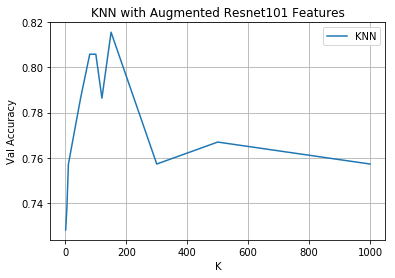

Best K       :  150
Best Accuracy:  0.8155339805825242


In [40]:
lk = [1, 5, 10, 50, 80, 100, 120, 150, 200, 300, 500, 1000]
laccu = []

for k in lk:
    neigh = KNeighborsClassifier(n_neighbors = k, metric = "cosine")
    neigh.fit(train_features, np.array(train_labels))
    val_hat = neigh.predict(val_features)

    laccu.append((val_hat == np.array(val_labels)).sum() / float(len(val_labels)))
    
plt.figure()
plt.plot(lk, laccu, label = "KNN")
#plt.plot([[lk[np.argmax(np.array(laccu))], min(laccu)], [lk[np.argmax(np.array(laccu))], max(laccu)]], marker='o')
plt.xlabel("K")
plt.ylabel("Val Accuracy")
plt.title("KNN with Augmented Resnet101 Features")
plt.legend()
plt.grid()
plt.show()

print("Best K       : ", lk[np.argmax(laccu)])
print("Best Accuracy: ", np.max(laccu))

In [40]:
neigh = KNeighborsClassifier(n_neighbors = 100, metric = "cosine")
neigh.fit(train_features, np.array(train_labels))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='cosine',
           metric_params=None, n_jobs=1, n_neighbors=100, p=2,
           weights='uniform')

In [41]:
val_hat = neigh.predict(val_features)
(val_hat == np.array(val_labels)).sum() / float(len(val_labels))

0.8252427184466019

In [75]:
test_yhat = neigh.predict(test_features.numpy())

## SVM

In [15]:
from sklearn.svm import SVC

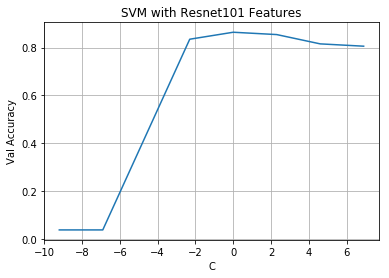

Best C       :  1
Best Accuracy:  0.8640776699029126


In [16]:
lc = [0.0001 ,0.001, 0.1, 1, 10, 100, 1000]
laccu = []

for c in lc:
    clf = SVC(C = c, gamma = 'auto')
    clf.fit(train_features, np.array(train_labels))
    val_hat = clf.predict(val_features)

    laccu.append((val_hat == np.array(val_labels)).sum() / float(len(val_labels)))
    
plt.figure()
plt.plot(np.log(lc), laccu)
#plt.plot([[lk[np.argmax(np.array(laccu))], min(laccu)], [lk[np.argmax(np.array(laccu))], max(laccu)]], marker='o')
plt.xlabel("C")
plt.ylabel("Val Accuracy")
plt.title("SVM with Resnet101 Features")
plt.grid()
plt.show()

print("Best C       : ", lc[np.argmax(laccu)])
print("Best Accuracy: ", np.max(laccu))

In [50]:
clf = SVC(C = 0.5, gamma = 'auto')
clf.fit(train_features, np.array(train_labels))
val_hat = clf.predict(val_features)
(val_hat == np.array(val_labels)).sum() / float(len(val_labels))

0.8543689320388349

In [53]:
test_yhat = clf.predict(test_features)

## Xgboost

In [12]:
import xgboost as xgb

In [13]:
dtrain = xgb.DMatrix(train_features, label = train_labels)
dval = xgb.DMatrix(val_features, label = val_labels)

In [27]:
param = {'max_depth': 2, 'eta': 0.1, 'silent': 1, 'objective': 'multi:softmax'}
param['nthread'] = 4
param['num_class'] = 20
param['eval_metric'] = 'merror'

evallist = [(dval, 'eval'), (dtrain, 'train')]

In [29]:
num_round = 50
bst = xgb.train(param, dtrain, num_round, evallist)

[0]	eval-merror:0.38835	train-merror:0.516189
[1]	eval-merror:0.378641	train-merror:0.444866
[2]	eval-merror:0.349515	train-merror:0.397317
[3]	eval-merror:0.359223	train-merror:0.362165
[4]	eval-merror:0.330097	train-merror:0.332655
[5]	eval-merror:0.31068	train-merror:0.309343
[6]	eval-merror:0.271845	train-merror:0.287697
[7]	eval-merror:0.291262	train-merror:0.268085
[8]	eval-merror:0.291262	train-merror:0.252729
[9]	eval-merror:0.300971	train-merror:0.239223
[10]	eval-merror:0.291262	train-merror:0.219981
[11]	eval-merror:0.281553	train-merror:0.207216
[12]	eval-merror:0.281553	train-merror:0.193525
[13]	eval-merror:0.281553	train-merror:0.181221
[14]	eval-merror:0.262136	train-merror:0.173636
[15]	eval-merror:0.271845	train-merror:0.16161
[16]	eval-merror:0.262136	train-merror:0.152544
[17]	eval-merror:0.271845	train-merror:0.141813
[18]	eval-merror:0.281553	train-merror:0.133025
[19]	eval-merror:0.271845	train-merror:0.125532
[20]	eval-merror:0.281553	train-merror:0.116004
[21]	

In [32]:
dtest = xgb.DMatrix(test_features)
test_yhat = bst.predict(dtest).astype(int)

## Write Result

In [36]:
def write_file(file_path, file_name, test_imgs, test_yhat):
    
    timestamp = datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d_%H:%M:%S')
    with open(os.path.join(file_path, file_name + timestamp + ".csv"), "w") as fp:
        fp.write("Id,Category\n")
        for i in range(len(test_imgs)):
            fp.write(test_imgs[i].split("/")[-1][:-4] + "," + str(test_yhat[i]) + "\n")

In [37]:
write_file("results/", "baseline", test_imgs, test_yhat)